In [1]:
import torch
import torch.nn as nn
import time
import numpy as np
import time
import pandas as pd
from torch.utils import data
import matplotlib.pyplot as plt
import random
import os
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Inverse scale of the prediction

In [2]:
direc = "/global/cscratch1/sd/rwang2/ODEs/Data/COVID/"
list_csv = sorted(os.listdir(direc))[:-6]
us = []
for file in list_csv:
    sample = pd.read_csv(direc + file).set_index("Province_State")[["Confirmed", "Recovered", "Deaths"]].sort_values(by = "Confirmed", ascending = False)
    us.append(sample.drop(['Diamond Princess', 'Grand Princess']))
us = pd.concat(us, axis=1, join='inner')[:50] 
us_data = us.values.reshape(50,-1,3)
us_data[us_data!=us_data] = 0
us_data[:,:,1] += us_data[:,:,2]
us_data_diff = np.diff(us_data, axis = 1)

# standardization
std = np.std(us_data_diff, axis = (1), keepdims = True)
avgs = np.mean(us_data_diff, axis = (1), keepdims = True)

In [7]:
results = torch.load("/global/cscratch1/sd/rwang2/ODEs/Main/Results/autofc.pt", map_location=torch.device('cpu'))
idx = 0
print(results["preds"].shape, results["trues"].shape)
preds = results["preds"][:,:,:,1].reshape(-1,50,7,3) * std + avgs
trues = results["trues"].reshape(-1,50,21,3) * std + avgs

w1_pred = np.cumsum(np.concatenate([np.expand_dims(us_data[:,132 + idx*7], axis = 1), preds[idx]], axis = 1), axis = 1)[:,-7:]
w1_true = np.cumsum(np.concatenate([np.expand_dims(us_data[:,132-14 + idx*7], axis = 1), trues[idx]], axis = 1), axis = 1)[:,1:]

preds = results["preds"][:,:,:,2].reshape(-1,50,7,3) * std + avgs
w1_pred_up = np.cumsum(np.concatenate([np.expand_dims(us_data[:,132 + idx*7], axis = 1), preds[idx]], axis = 1), axis = 1)[:,-7:]
w1_true_up = np.cumsum(np.concatenate([np.expand_dims(us_data[:,132-14 + idx*7], axis = 1), trues[idx]], axis = 1), axis = 1)[:,1:]

preds = results["preds"][:,:,:,0].reshape(-1,50,7,3) * std + avgs
w1_pred_lower = np.cumsum(np.concatenate([np.expand_dims(us_data[:,132 + idx*7], axis = 1), preds[idx]], axis = 1), axis = 1)[:,-7:]
w1_true_lower = np.cumsum(np.concatenate([np.expand_dims(us_data[:,132-14 + idx*7], axis = 1), trues[idx]], axis = 1), axis = 1)[:,1:]


preds_total = []
for i in range(2,6):
    results = torch.load("/global/cscratch1/sd/rwang2/ODEs/Main/Results/AutoODE_0823_" +str(i) + ".pt", map_location=torch.device('cpu'))
    preds_total.append(results["preds"][:,-7:])
preds_total = np.array(preds_total)
ode_std = np.std(preds_total, axis = 0)

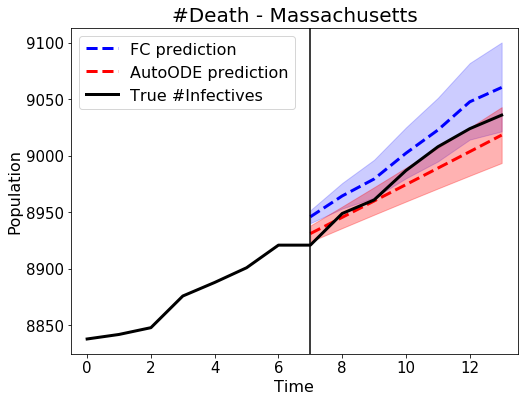

In [17]:
state = 2
feat = 2
x = np.arange(0, 21, 1)[:14]
fig=plt.figure(figsize=(8, 6))

# plt.plot(x[-7:], preds[idx, state,:,0], 'blue', alpha= 0.5, lw=4, linestyle = "--", label='Seq2Seq Prediction')
plt.plot(x[-7:], w1_pred[state,:,feat], 'blue', alpha= 1, lw=3, linestyle = "--", label='FC prediction')
# plt.plot(x[-7:], w1_pred_up[state,:,0], 'blue', alpha= 0.5, lw=1, linestyle = "--")#, label='Seq2Seq Prediction'
# plt.plot(x[-7:], w1_pred_lower[state,:,0], 'blue', alpha= 0.5, lw=1, linestyle = "--")#, label='Seq2Seq Prediction'
plt.fill_between(x[-7:], w1_pred_lower[state,:,feat], w1_pred_up[state,:,feat], color='b', alpha=.2)

plt.plot(x[-7:], ode_preds[state,-7:,feat], 'red', alpha= 1, lw=3, linestyle = "--", label='AutoODE prediction')
plt.fill_between(x[-7:], ode_preds[state,-7:,feat] - ode_std[state,:,feat], 
                 ode_preds[state,-7:,feat] + ode_std[state,:,feat],  color='red', alpha=.3)


#plt.plot(x[-7:], w1_pred_lower[state,:,0], 'blue', alpha= 0.5, lw=1, linestyle = "--",  label='AutoODE')#, label='Seq2Seq Prediction'

#plt.plot(x, trues[idx, state,:,0], 'black', alpha=1, lw=2,  label= 'True #Infectives')
plt.plot(x, w1_true[state,7:,feat], 'black', alpha=1, lw=3,  label= 'True #Infectives')
# plt.plot(x, w1_true[state,:,0], 'black', alpha=1, lw=2,  label= 'True #Infectives')
# plt.plot(x, w1_true[state,:,0], 'black', alpha=1, lw=2,  label= 'True #Infectives')

plt.axvline(7, color = "black")
plt.xlabel('Time', size = 16)
plt.ylabel('Population', size = 16)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlim(-0.5,13.5)

#plt.grid(b=True, c='w', lw=2, ls='-')
plt.legend(fontsize = 16, loc = 2)

plt.title( "#Death - " + us.index[state], fontsize = 20)#+ r"$N=10000, I_0 = 10, \beta = 0.8, \gamma = 0.1$"+ "- 07/06~07/12"
plt.savefig(us.index[state] + "_D.png", dpi = 400 , bbox_inches = "tight")   #"SuEIRD_Corr_" + us.index[idx] + ".png" 
plt.show()